In [1]:
import os

import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
import seaborn as sns
import gpytorch
import torch

from REStats.utils import load_SCADA, filter_outliers, downsample, standardize
from REStats.plots import save_figs
from REStats.models import calc_iec_power_curve, power_curve

In [2]:
sns.set_theme()

In [3]:
figs = {}
SAVE_FIGS = True

In [4]:
wt = load_SCADA(2020)

In [5]:
cut_out = 17.6 # TODO: infer?
wt_input = downsample(wt)
wt_input = wt_input[wt_input.wind_speed <= cut_out]

wt_filtered = filter_outliers(wt_input)
wt_filtered = wt_filtered.dropna()
wt_std = standardize(wt_filtered)

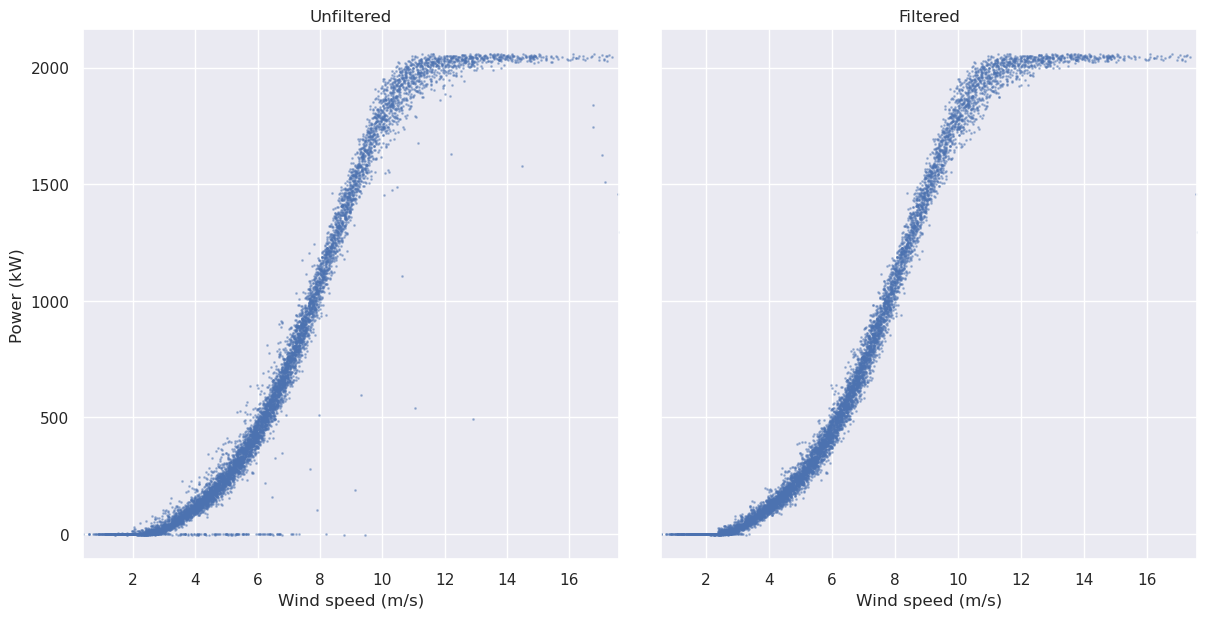

In [6]:
filtered_pc, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
filtered_pc.tight_layout()
axes[0].set_ylabel("Power (kW)")
for ax in axes:
    ax.set_xmargin(0)
    ax.set_xlabel("Wind speed (m/s)")

axes[0].set_title("Unfiltered")
axes[1].set_title("Filtered")
axes[0].scatter(wt_input.wind_speed, wt_input.power, s=1, alpha=0.4)
axes[1].scatter(wt_filtered.wind_speed, wt_filtered.power, s=1, alpha=0.4)

figs["filtered_pc"] = filtered_pc

In [7]:
kbd = KBinsDiscretizer(n_bins=20, encode="ordinal")
bins = kbd.fit_transform(wt_filtered.wind_speed.to_numpy()[:, None])

train, test = train_test_split(wt_filtered, stratify=bins, train_size=800, test_size=1000, random_state=1)

train["power_std"] = (train.power - train.power.mean())/train.power.std()

train

,wind_speed,wind_dir,power,turbulence_intensity,power_std
Date,,,,,
2020-08-16 05:00:00,3.306489,47.917287,41.060810,0.089388,-1.039526
2020-01-15 04:00:00,6.300967,215.481865,534.113880,0.091188,-0.299360
2020-04-03 23:00:00,4.544026,242.952289,153.402214,0.090071,-0.870880
2020-03-01 15:00:00,11.194760,237.713262,1944.092501,0.072124,1.817283
2020-12-19 13:00:00,8.887445,201.414075,1473.054520,0.052625,1.110166
...,...,...,...,...,...
2020-01-16 14:00:00,12.140788,170.094381,2007.527366,0.062860,1.912511
2020-09-08 23:00:00,6.604373,229.848345,586.879720,0.078359,-0.220149
2020-12-21 11:00:00,6.698367,203.007338,653.652909,0.052317,-0.119910


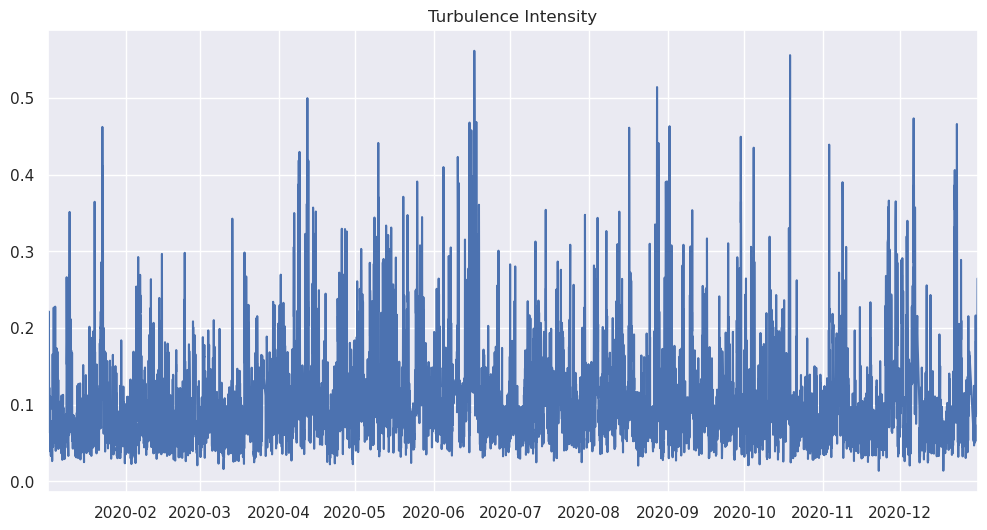

In [30]:
ti_fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xmargin(0)

ax.set_title("Turbulence Intensity")
wt_fil_sort = wt_filtered.sort_index()
ax.plot(wt_fil_sort.index, wt_fil_sort.turbulence_intensity)

figs["TI"] = ti_fig

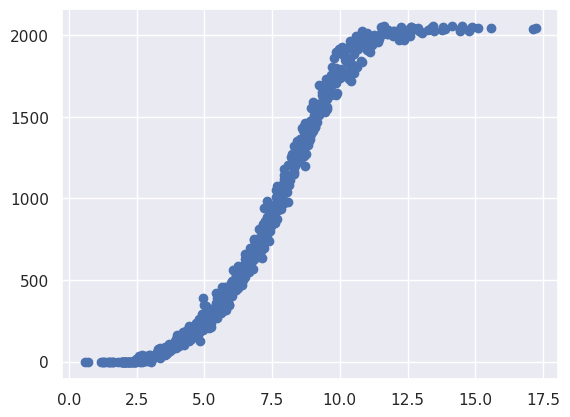

In [10]:
plt.scatter(train.wind_speed, train.power)

## IEC Method

In [11]:
kbd = KBinsDiscretizer(n_bins=20, encode="ordinal")
bins = kbd.fit_transform(wt_filtered.wind_speed.to_numpy()[:, None])

iec_train, iec_test = train_test_split(wt_filtered, stratify=bins, test_size=2000, random_state=1)


iec_pc = calc_iec_power_curve(iec_train, cut_out)
iec_pc.tail()

,wind_speed,wind_dir,power,turbulence_intensity
wind_speed,,,,
"(15.0, 15.5]",15.237487,226.233049,2042.111963,0.060348
"(15.5, 16.0]",15.714261,236.683677,2041.316870,0.056518
"(16.0, 16.5]",16.245194,234.976191,2045.182272,0.078045
"(16.5, 17.0]",16.713853,224.664286,2042.857422,0.082382
"(17.0, 17.5]",17.195320,232.214207,2043.404796,0.064949


In [12]:
iec_pred = [iec_pc.loc[ws, "power"] for ws in iec_test.wind_speed]

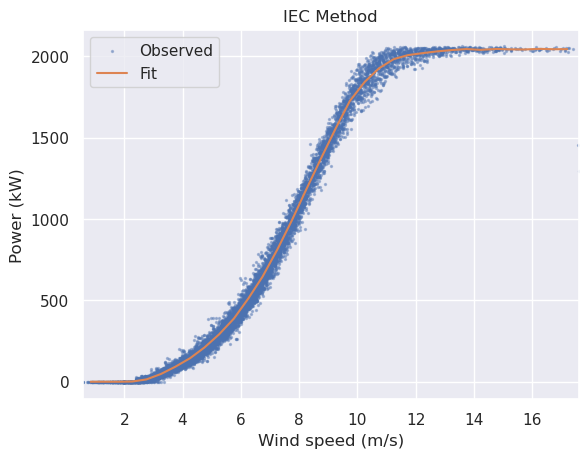

In [13]:
iec_pc_fig, ax = plt.subplots()
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.set_title("IEC Method")

ax.scatter(wt_filtered.wind_speed, wt_filtered.power, s=2, alpha=.4, color="C0", label="Observed")
ax.plot(iec_pc.wind_speed, iec_pc.power, color="C1", label="Fit")

ax.legend()

figs["iec_pc"] = iec_pc_fig

In [14]:
rmse = mean_squared_error(iec_pred, iec_test.power, squared=False)

print(f"IEC Test RMSE: {rmse} kW")

IEC Test RMSE: 55.77071784689642 kW


## Wind speed only

In [15]:
train_std = standardize(train)

X_train = torch.tensor(train_std.wind_speed)
y_train = torch.tensor(train_std.power_std)

model, likelihood = power_curve.fit(X_train, y_train)

Iter 1/100 - Loss: 0.766   lengthscale: [[0.6931471824645996]]   noise: 0.693
Iter 2/100 - Loss: 0.728   lengthscale: [[0.7443966269493103]]   noise: 0.644
Iter 3/100 - Loss: 0.690   lengthscale: [[0.7979509830474854]]   noise: 0.598
Iter 4/100 - Loss: 0.652   lengthscale: [[0.8536456227302551]]   noise: 0.554
Iter 5/100 - Loss: 0.612   lengthscale: [[0.9112750291824341]]   noise: 0.513
Iter 6/100 - Loss: 0.573   lengthscale: [[0.9705725908279419]]   noise: 0.474
Iter 7/100 - Loss: 0.532   lengthscale: [[1.0311851501464844]]   noise: 0.437
Iter 8/100 - Loss: 0.491   lengthscale: [[1.0926493406295776]]   noise: 0.403
Iter 9/100 - Loss: 0.450   lengthscale: [[1.1543807983398438]]   noise: 0.370
Iter 10/100 - Loss: 0.408   lengthscale: [[1.2156779766082764]]   noise: 0.340
Iter 11/100 - Loss: 0.365   lengthscale: [[1.275731086730957]]   noise: 0.312
Iter 12/100 - Loss: 0.322   lengthscale: [[1.3336293697357178]]   noise: 0.286
Iter 13/100 - Loss: 0.279   lengthscale: [[1.3883627653121948]

In [16]:
fit_x = np.linspace(0, cut_out+1.5, 200)
fit_x_std = (fit_x - train.wind_speed.mean())/train.wind_speed.std()
fit_x_std = torch.tensor(fit_x_std, dtype=torch.float32)
fit_pred = power_curve.predict(model, likelihood, fit_x_std)

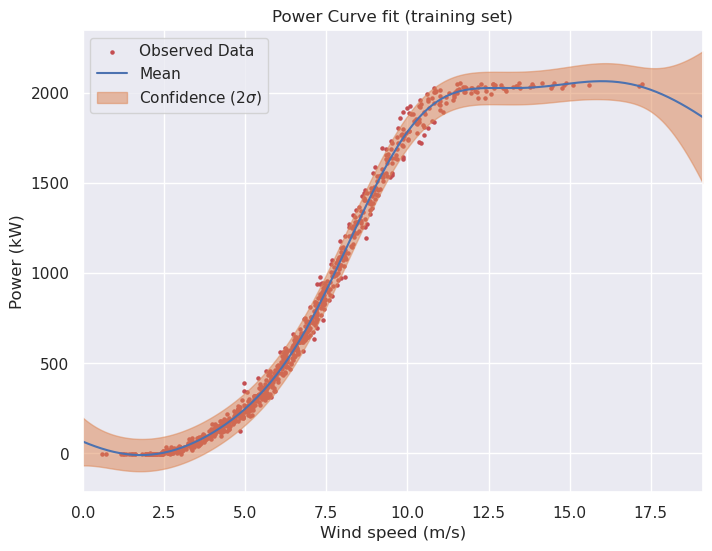

In [17]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_xmargin(0)
    ax.set_title("Power Curve fit (training set)")
    ax.set_xlabel("Wind speed (m/s)")
    ax.set_ylabel("Power (kW)")

    # Get upper and lower confidence bounds
    lower, upper = fit_pred.confidence_region()
    # Plot training data
    ax.scatter(train.wind_speed, train.power, s=5, color="C3")
    # Plot predictive means as blue line
    ax.plot(fit_x, fit_pred.mean.numpy() * train.power.std() + train.power.mean(), color="C0")
    # Shade between the lower and upper confidence bounds
    lower_tf = lower.numpy() * train.power.std() + train.power.mean()
    upper_tf = upper.numpy() * train.power.std() + train.power.mean()
    ax.fill_between(fit_x, lower_tf, upper_tf, color="C1", alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence (2$\sigma$)'])
    
figs["pc_train"] = f

In [18]:
test_sort = test.sort_values("wind_speed")
test_sort_std = standardize(test_sort, ref_df=train)
X_test_torch = torch.tensor(test_sort_std.wind_speed)

test_pred = power_curve.predict(model, likelihood, X_test_torch)

In [19]:
test_sort_std

,wind_speed,wind_dir,power,turbulence_intensity
Date,,,,
2020-09-29 15:00:00,-1.963603,-2.533608,-1.101703,0.364628
2020-12-06 15:00:00,-1.913338,0.128512,-1.102252,0.386533
2020-06-18 14:00:00,-1.907054,-1.536675,-1.101593,0.332035
2020-12-06 13:00:00,-1.869683,0.184591,-1.102427,0.294423
2020-11-08 13:00:00,-1.847224,-0.825949,-1.101936,0.389998
...,...,...,...,...
2020-12-26 20:00:00,3.064306,-0.250550,1.971484,0.056759
2020-02-22 06:00:00,3.084439,-0.145558,1.965516,0.044369
2020-02-09 15:00:00,3.333749,-0.035519,1.962306,0.105616


In [20]:
test_pred_tf = test_pred.mean.numpy() * train.power.std() + train.power.mean()
test_rmse = mean_squared_error(test_pred_tf, test_sort.power, squared=False)

print(f"Test RMSE: {test_rmse} kW")

Test RMSE: 39.53300355441898 kW


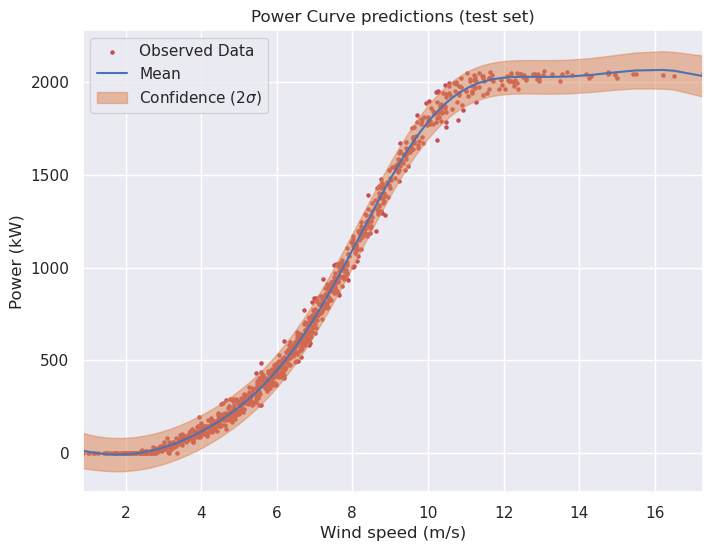

In [21]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_xmargin(0)
    ax.set_title("Power Curve predictions (test set)")
    ax.set_xlabel("Wind speed (m/s)")
    ax.set_ylabel("Power (kW)")
    
    # Get upper and lower confidence bounds
    lower, upper = test_pred.confidence_region()
    # Plot training data
    ax.scatter(test.wind_speed, test.power, s=5, color="C3")
    # Plot predictive means as blue line
    ax.plot(test_sort.wind_speed, test_pred_tf, color="C0")
    # Shade between the lower and upper confidence bounds
    lower_tf = lower.numpy() * train.power.std() + train.power.mean()
    upper_tf = upper.numpy() * train.power.std() + train.power.mean()
    ax.fill_between(test_sort.wind_speed, lower_tf, upper_tf, color="C1", alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence (2$\sigma$)'])
    
figs["pc_test"] = f

## Wind speed + direction w/ARD

In [22]:
X_test2 = torch.tensor(test_sort_std[["wind_speed", "wind_dir"]].values, dtype=torch.float32)

X_train2 = torch.tensor(train_std[["wind_speed", "wind_dir"]].values, dtype=torch.float32)
y_train2 = torch.tensor(train_std.power, dtype=torch.float32)

model2, likelihood2 = power_curve.fit(X_train2, y_train2, dims=2)
test_pred2 = power_curve.predict(model2, likelihood2, X_test2)

Iter 1/100 - Loss: 0.805   lengthscale: [[0.6931471824645996, 0.6931471824645996]]   noise: 0.693
Iter 2/100 - Loss: 0.764   lengthscale: [[0.7443966269493103, 0.7443966269493103]]   noise: 0.644
Iter 3/100 - Loss: 0.724   lengthscale: [[0.7978856563568115, 0.7979797124862671]]   noise: 0.598
Iter 4/100 - Loss: 0.683   lengthscale: [[0.8533650636672974, 0.8537632822990417]]   noise: 0.554
Iter 5/100 - Loss: 0.643   lengthscale: [[0.9105194807052612, 0.9116041660308838]]   noise: 0.513
Iter 6/100 - Loss: 0.602   lengthscale: [[0.9689655900001526, 0.9713542461395264]]   noise: 0.474
Iter 7/100 - Loss: 0.560   lengthscale: [[1.0282621383666992, 1.0328607559204102]]   noise: 0.437
Iter 8/100 - Loss: 0.518   lengthscale: [[1.0879266262054443, 1.0959622859954834]]   noise: 0.403
Iter 9/100 - Loss: 0.476   lengthscale: [[1.1474497318267822, 1.1604819297790527]]   noise: 0.370
Iter 10/100 - Loss: 0.433   lengthscale: [[1.2062981128692627, 1.2262260913848877]]   noise: 0.340
Iter 11/100 - Loss:

Iter 84/100 - Loss: -1.270   lengthscale: [[1.189947247505188, 4.830774784088135]]   noise: 0.004
Iter 85/100 - Loss: -1.270   lengthscale: [[1.1886796951293945, 4.855675220489502]]   noise: 0.004
Iter 86/100 - Loss: -1.270   lengthscale: [[1.1879785060882568, 4.881015777587891]]   noise: 0.004
Iter 87/100 - Loss: -1.270   lengthscale: [[1.1877678632736206, 4.906810283660889]]   noise: 0.004
Iter 88/100 - Loss: -1.270   lengthscale: [[1.187848687171936, 4.933069705963135]]   noise: 0.004
Iter 89/100 - Loss: -1.270   lengthscale: [[1.1879980564117432, 4.9597930908203125]]   noise: 0.004
Iter 90/100 - Loss: -1.270   lengthscale: [[1.1879719495773315, 4.986976623535156]]   noise: 0.004
Iter 91/100 - Loss: -1.270   lengthscale: [[1.1875863075256348, 5.014608860015869]]   noise: 0.004
Iter 92/100 - Loss: -1.270   lengthscale: [[1.1867179870605469, 5.042677402496338]]   noise: 0.004
Iter 93/100 - Loss: -1.270   lengthscale: [[1.1853599548339844, 5.071165084838867]]   noise: 0.004
Iter 94/100

In [23]:
test_pred_tf2 = test_pred2.mean.numpy() * train.power.std() + train.power.mean()
test_rmse2 = mean_squared_error(test_pred_tf2, test_sort.power, squared=False)

print(f"Test RMSE: {test_rmse2} kW")

Test RMSE: 39.4693606279397 kW


## Wind speed, direction, and TI w/ARD

In [24]:
X_test3 = torch.tensor(test_sort_std[["wind_speed", "wind_dir", "turbulence_intensity"]].values, dtype=torch.float32)

X_train3 = torch.tensor(train_std[["wind_speed", "wind_dir", "turbulence_intensity"]].values, dtype=torch.float32)
y_train3 = torch.tensor(train_std.power, dtype=torch.float32)

model3, likelihood3 = power_curve.fit(X_train3, y_train3, dims=3)
test_pred3 = power_curve.predict(model3, likelihood3, X_test3)

Iter 1/100 - Loss: 0.806   lengthscale: [[0.6931471824645996, 0.6931471824645996, 0.6931471824645996]]   noise: 0.693
Iter 2/100 - Loss: 0.766   lengthscale: [[0.7443966269493103, 0.7443966269493103, 0.7443963885307312]]   noise: 0.644
Iter 3/100 - Loss: 0.725   lengthscale: [[0.7978857159614563, 0.7979798316955566, 0.7978427410125732]]   noise: 0.598
Iter 4/100 - Loss: 0.685   lengthscale: [[0.853365421295166, 0.853763222694397, 0.8532406687736511]]   noise: 0.554
Iter 5/100 - Loss: 0.644   lengthscale: [[0.9105202555656433, 0.9116033911705017, 0.9103240966796875]]   noise: 0.513
Iter 6/100 - Loss: 0.603   lengthscale: [[0.9689648151397705, 0.9713519811630249, 0.9688189625740051]]   noise: 0.474
Iter 7/100 - Loss: 0.561   lengthscale: [[1.0282492637634277, 1.0328572988510132, 1.0284571647644043]]   noise: 0.437
Iter 8/100 - Loss: 0.519   lengthscale: [[1.0878727436065674, 1.0959609746932983, 1.0889917612075806]]   noise: 0.403
Iter 9/100 - Loss: 0.477   lengthscale: [[1.14729654788970

Iter 76/100 - Loss: -1.280   lengthscale: [[1.1841837167739868, 4.537665367126465, 0.9818553924560547]]   noise: 0.003
Iter 77/100 - Loss: -1.281   lengthscale: [[1.1934795379638672, 4.551161766052246, 0.9428907036781311]]   noise: 0.003
Iter 78/100 - Loss: -1.282   lengthscale: [[1.199654459953308, 4.56439733505249, 0.917231023311615]]   noise: 0.003
Iter 79/100 - Loss: -1.283   lengthscale: [[1.2023417949676514, 4.5775146484375, 0.9038833975791931]]   noise: 0.003
Iter 80/100 - Loss: -1.285   lengthscale: [[1.201498031616211, 4.590648651123047, 0.9015265107154846]]   noise: 0.003
Iter 81/100 - Loss: -1.286   lengthscale: [[1.1976196765899658, 4.603911399841309, 0.9087117314338684]]   noise: 0.003
Iter 82/100 - Loss: -1.286   lengthscale: [[1.1914488077163696, 4.617413520812988, 0.9238576292991638]]   noise: 0.003
Iter 83/100 - Loss: -1.287   lengthscale: [[1.1838772296905518, 4.6312456130981445, 0.9453967213630676]]   noise: 0.004
Iter 84/100 - Loss: -1.288   lengthscale: [[1.1757938

In [25]:
test_pred_tf3 = test_pred3.mean.numpy() * train.power.std() + train.power.mean()
test_rmse3 = mean_squared_error(test_pred_tf3, test_sort.power, squared=False)

print(f"Test RMSE: {test_rmse3} kW")

Test RMSE: 37.48780040189494 kW


In [26]:
if SAVE_FIGS:
    save_figs(figs)